## Doc2vec and Classification together

The consumer complains dataset can be found here: https://catalog.data.gov/dataset/consumer-complaint-database

If you want to experiment with another data set:
A very large set of Stack Overflow questions and tags is available at 
https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

### Part 3
Perform document embedding using doc2vec/sent2vec/para2vec from Gensim (several variants of doc2vec, which one are you using?).

Preprocess the dataset

Use doc2vec/sent2vec/para2vec for Text Representation - Data 3

Evaluate different machine learning models and identify the best one.

Compare model performance Data 1, Data 2 and Data 3. Perform 5-fold cross-validation and compare results of best model using statistical tests

In [140]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\ooles\Anaconda3\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


classify complaints into pre-defined classes

In [141]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

C:\Users\ooles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,narrative,Product
60,I am disputing this debt for XXXX XXXX that is...,Debt collection
91,Ok education credit management corporation XXX...,Debt collection
146,The Account from Ability Recovery Services has...,"Credit reporting, credit repair services, or o..."
171,I made cash & check deposit at my banks atm on...,Checking or savings account
172,Monterey Collection is trying to collect on a ...,Debt collection
173,I was looking through my credit karma and see ...,"Credit reporting, credit repair services, or o..."
174,"Hi, I am constantly being harassed by a compan...",Debt collection
187,I ATTENDED XXXX XXXX XXXX FOR A WHILE THEN COU...,Debt collection
189,First I received communications from Source RM...,Debt collection
208,On Friday XX/XX/18 I was called 6 times in a r...,Debt collection


In [142]:
df = df.sample(frac = 0.03)

In [143]:
df.shape

(10637, 2)

In [144]:
df.index = range(df.shape[0])#reindex

In [145]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

2103736

In [146]:
df.head()

,narrative,Product
0,"XX/XX/XXXX, I contacted you about a problem I ...",Consumer Loan
1,Arstrat Debtor information and payment online ...,Debt collection
2,We have been restlessly attempting to resolve ...,Vehicle loan or lease
3,What happened? \n\nI bought a car on XXXX XXXX...,"Credit reporting, credit repair services, or o..."
4,When the credit agency deleted the fraud addre...,"Credit reporting, credit repair services, or o..."


## Exploring the data

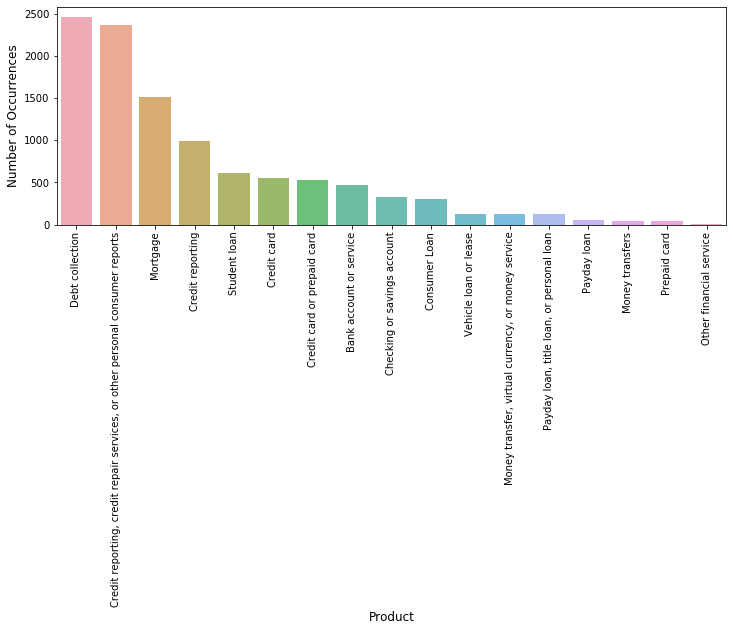

In [147]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [148]:
df['Product'].value_counts()

Debt collection                                                                 2460
Credit reporting, credit repair services, or other personal consumer reports    2367
Mortgage                                                                        1515
Credit reporting                                                                 992
Student loan                                                                     611
Credit card                                                                      554
Credit card or prepaid card                                                      533
Bank account or service                                                          472
Checking or savings account                                                      323
Consumer Loan                                                                    301
Vehicle loan or lease                                                            126
Money transfer, virtual currency, or money service               

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.


In [149]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [150]:
print_complaint(11)

I had my mortgage through XXXX XXXX XXXX and was sold to Specialized Loan company. I have been unemployed since XXXX and have been going through the XXXX process since then. I have explained this to this company on multiple occassions. I was in a government program to help with my payments in hopes that my XXXX claim would be approved and I could maintain my payments on my own. After the program ended I filed for 2 modifications to help me keep my home. The first one was denied due to the fact they increased my payment to see if I could pay the new amount before the final modification was approved. The second was denied because my income was lowered and they said there was not a program I qualified for and that if I did n't make my account current they would start foreclosure proceedings. In XXXX XXXX I borrowed from everyone I could and came up with over {$4000.00} to save my home. I made the payment through my bank to them which was sent back. I called and questioned them and they sa

In [151]:
print_complaint(12)

I was shocked when reviewing my credit report and found a late payment on the date below : 30 days late as of XX/XX/2017 60 days late as of XX/XX/2017 I am not sure how this happened. I believe I made my payments to you when I received my statements. My only thought is that my statement did not get to me.
Product: Credit card or prepaid card


## Text preprocessing

In [152]:
#To do: Text preprocessing
#use BeautifulSoup and regular expressions to clean the text
# function to convert text to lower-case and strip punctuation/symbols from words and so on

from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [153]:
df['narrative'] = df['narrative'].apply(cleanText)


In [155]:
df['narrative'][11]

"i had my mortgage through    and was sold to specialized loan company. i have been unemployed since  and have been going through the  process since then. i have eplained this to this company on multiple occassions. i was in a government program to help with my payments in hopes that my  claim would be approved and i could maintain my payments on my own. after the program ended i filed for 2 modifications to help me keep my home. the first one was denied due to the fact they increased my payment to see if i could pay the new amount before the final modification was approved. the second was denied because my income was lowered and they said there was not a program i qualified for and that if i did n't make my account current they would start foreclosure proceedings. in   i borrowed from everyone i could and came up with over {$4000.00} to save my home. i made the payment through my bank to them which was sent back. i called and questioned them and they said that since i was behind they 

## Train test split

train/test split of 70/30

In [76]:
train, test = train_test_split(df, test_size=0.3, random_state=42)


### Tokenization 

remove stop-words and tokenize text using NLTK tokenizer. 
Tagging every complaint narrative with its product.

In [77]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [78]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)# create the tags
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

This is what a training entry looks like - an example complaint narrative tagged by 'Student loan'.

In [157]:
train_tagged.values[11]

TaggedDocument(words=["'ve", 'called', 'monthly', 'to', 'try', 'and', 'arrange', 'payments', 'and', 'navient', 'will', 'not', 'work', 'with', 'me', 'dont', 'have', 'specific', 'dates', 'now', 'am', 'being', 'sent', 'to', 'collections'], tags=['Student loan'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm 
names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding 
algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

## DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. 
The paragraph vectors are obtained by training a neural network on the task of predicting a 
probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences.


In [80]:
import multiprocessing
cores = multiprocessing.cpu_count()

If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
300- dimensional feature vectors.
min_count=2, ignores all words with total frequency lower than this.
negative=5 , specifies how many “noise words” should be drawn.
hs=0 , and negative is non-zero, negative sampling will be used.
sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [81]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████████| 7445/7445 [00:00<00:00, 829413.62it/s]


In [159]:
#Training a doc2vec model is rather straight-forward in Gensim, we initialize the model and train for 30 epochs.

In [82]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 7445/7445 [00:00<00:00, 1492881.07it/s]


Wall time: 38.5 s


# Building the final vector feature for the classifier

In [83]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [91]:
from imblearn.over_sampling import SMOTE

In [85]:
#!pip install imblearn

In [87]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [88]:
pd.DataFrame(y_train)[0].value_counts()

Debt collection                                                                 1725
Credit reporting, credit repair services, or other personal consumer reports    1687
Mortgage                                                                        1072
Credit reporting                                                                 653
Student loan                                                                     430
Credit card                                                                      396
Credit card or prepaid card                                                      383
Bank account or service                                                          290
Checking or savings account                                                      241
Consumer Loan                                                                    176
Vehicle loan or lease                                                            101
Money transfer, virtual currency, or money service               

In [114]:
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({'Debt collection': 1725, 'Credit reporting, credit repair services, or other personal consumer reports': 1725, 'Checking or savings account': 1725, 'Bank account or service': 1725, 'Credit card': 1725, 'Consumer Loan': 1725, 'Mortgage': 1725, 'Credit reporting': 1725, 'Student loan': 1725, 'Payday loan, title loan, or personal loan': 1725, 'Credit card or prepaid card': 1725, 'Vehicle loan or lease': 1725, 'Money transfer, virtual currency, or money service': 1725, 'Payday loan': 1725, 'Money transfers': 1725, 'Other financial service': 1725, 'Prepaid card': 1725})


In [163]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [164]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.25532581453634084
Testing F1 score: 0.18543540293228575


In [162]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.05858395989974937
Testing F1 score: 0.07708946590512519


C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

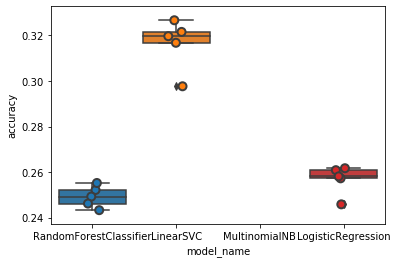

In [117]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# HINT: Use boxplots and stripplot below to compare the models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()


In [118]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.316488
LogisticRegression        0.256777
MultinomialNB                  NaN
RandomForestClassifier    0.249241
Name: accuracy, dtype: float64

C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ooles\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

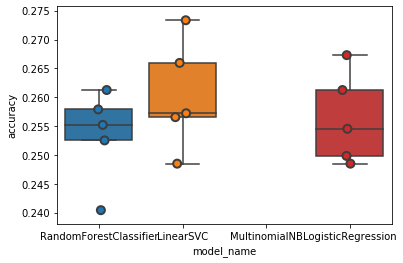

In [168]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# HINT: Use boxplots and stripplot below to compare the models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
         entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [169]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.260309
LogisticRegression        0.256279
MultinomialNB                  NaN
RandomForestClassifier    0.253459
Name: accuracy, dtype: float64